# **Deforum FLUX**

In [14]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

NVIDIA H100 80GB HBM3, 81559 MiB, 38810 MiB


# Setup

In [15]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

!pip install -q -r requirements.txt
sys.path.extend(['./deforum_flux', './deforum_flux/src', './x-flux'])


In [21]:
import torch
import random
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.prompts import Prompts

import argparse
import sys
import os
import re
import time
from glob import iglob
from io import BytesIO

import torch
from dataclasses import dataclass

from einops import rearrange
from PIL import ExifTags, Image
from torchvision import transforms
from transformers import pipeline
from src.flux.modules.layers import DoubleStreamBlockLoraProcessor
from src.flux.sampling import denoise, get_noise, get_schedule, prepare, unpack
from src.flux.util import (
    configs, 
    load_ae, 
    load_clip,
    load_flow_model_quintized,
    load_flow_model, 
    load_t5
)


In [27]:
class Model: 
    def __init__(self, name="flux-dev", quantized=True):
        self.dit, self.ae, self.t5, self.clip = self.get_models(name, 'cuda', offload=False, is_schnell=False, quantized=quantized)
        
    def get_models(self, name:str, device: torch.device, offload: bool, is_schnell: bool, quantized=True):
        t5 = load_t5(device, max_length=256 if is_schnell else 512)
        clip = load_clip(device)
        if quantized:
            dit = load_flow_model_quintized("flux-dev-fp8", device="cpu" if offload else device)
        else:
            dit = load_flow_model(name, device="cpu" if offload else device)
        ae = load_ae(name, device="cpu" if offload else device)
        return dit, ae, t5, clip

In [28]:
#@markdown **Path Setup**
def PathSetup():
    output_path = "outputs" #@param {type:"string"}
    #      
    # models_path = "./models" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())

#@markdown **Model Setup**
def ModelSetup():
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    map_location = "cuda" #@param ["cpu", "cuda"]
    device = torch.device(map_location)
    model = Model("flux-dev-fp8", quantized=True)
    return locals()

root.__dict__.update(ModelSetup())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Init model


flux-dev-fp8.safetensors:   0%|          | 0.00/11.9G [00:00<?, ?B/s]

flux_dev_quantization_map.json:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

Loading checkpoint
Start a quantization process...
Model is quantized!
Init AE


# Settings

In [29]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'Interpolation' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(7.5)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    # strength_schedule = "0: (0.65), 24: (0.65), 25: (0.8), 47: (0.8), 48: (0.65)"#@param {type:"string"}
    strength_schedule = "0: (0.65), 12: (0.70), 24: (0.8), 36: (0.85), 38: (0.65)"
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('Default Flux Scheduler')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 RGB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 32 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20240810001544" #@param {type:"string"}

    return locals()



In [30]:
# prompts
prompts = {
    0: "super realism, 4k, a highly detailed close-up view of a woman's mesmerizing blue eye, with realistic reflections and an intense natural sparkle. The iris displays intricate patterns of deep blues and subtle hints of lighter hues, while delicate veins add to the eye's natural complexity. Soft, diffused lighting enhances the eye's depth, with a blurred background to emphasize the eye's captivating beauty and detail.",
    12: "super realism, 4k, the woman's blue eye transforms into a stunning cosmic scene. Tiny, luminous stars begin to appear within the iris, creating a sense of depth. Nebulae with swirling, ethereal colors—rich purples, blues, and pinks—emerge, blending seamlessly with the natural textures of the eye. The transition is smooth, with the cosmic elements gradually overtaking the eye's surface, adding a layer of wonder and vastness.",
    24: "super realism, 4k, grand cosmic vista contained within the eye. The eye now features swirling galaxies with vibrant, spiraling arms, and floating celestial bodies such as distant planets and shimmering asteroids. Nebulae continue to swirl with dynamic, vivid colors, creating a surreal and expansive universe that feels both infinite and intimately contained within the eye's bounds.",
    36: "super realism, 4k, The swirling galaxies and celestial bodies are now accompanied by pulsating stars and radiant supernovae, with intricate light effects and a sense of motion. The smooth transition ensures that the cosmic wonder within the eye remains captivating and visually coherent.",
}

# can be a string, list, or dictionary
# prompts = [
#    # "a beautiful lake by Asher Brown Durand, trending on Artstation",
#    "a beautiful portrait of a woman by Artgerm, trending on Artstation",
# ]
#prompts = "a beautiful lake by Asher Brown Durand, trending on Artstation"

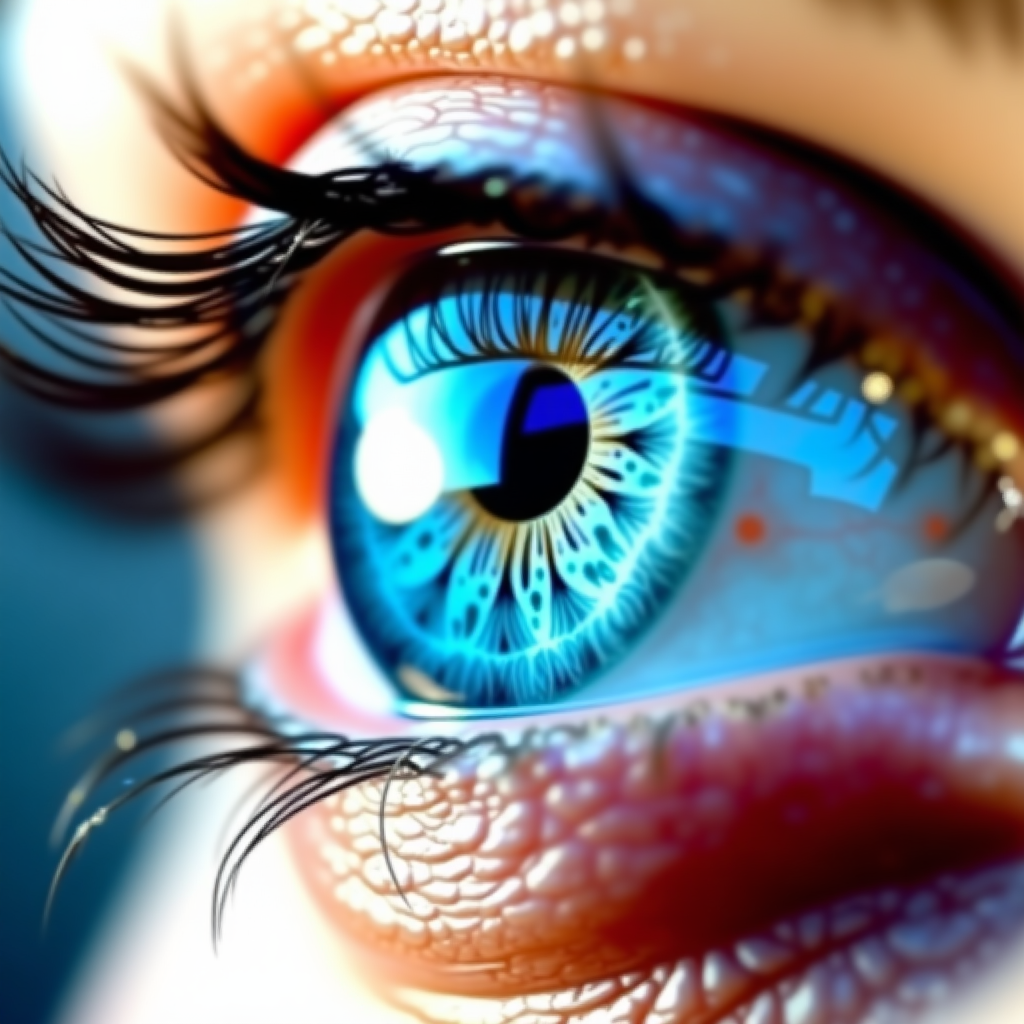

Seed set to 2996838012


In [ ]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 1024 #@param
    H = 1024 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'Flux Default Sampler' # sampler schedule is not supported
    steps = 30 #@param
    scale = 3.5 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 1.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.01 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    # colormatch_image = None
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast' 
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
    
if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# get prompts
cond, uncond = Prompts(prompt=prompts).as_dict()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

# Create Video From Frames

In [ ]:
#@markdown **New Version**
skip_video_for_run_all = False #@param {type: 'boolean'}
create_gif = False #@param {type: 'boolean'}

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:

    from helpers.ffmpeg_helpers import get_extension_maxframes, get_auto_outdir_timestring, get_ffmpeg_path, make_mp4_ffmpeg, make_gif_ffmpeg, patrol_cycle

    def ffmpegArgs():
        ffmpeg_mode = "auto" #@param ["auto","manual","timestring"]
        ffmpeg_outdir = "" #@param {type:"string"}
        ffmpeg_timestring = "" #@param {type:"string"}
        ffmpeg_image_path = "" #@param {type:"string"}
        ffmpeg_mp4_path = "" #@param {type:"string"}
        ffmpeg_gif_path = "" #@param {type:"string"}
        ffmpeg_extension = "png" #@param {type:"string"}
        ffmpeg_maxframes = 200 #@param
        ffmpeg_fps = 12 #@param

        # determine auto paths
        if ffmpeg_mode == 'auto':
            ffmpeg_outdir, ffmpeg_timestring = get_auto_outdir_timestring(args,ffmpeg_mode)
        if ffmpeg_mode in ["auto","timestring"]:
            ffmpeg_extension, ffmpeg_maxframes = get_extension_maxframes(args,ffmpeg_outdir,ffmpeg_timestring)
            ffmpeg_image_path, ffmpeg_mp4_path, ffmpeg_gif_path = get_ffmpeg_path(ffmpeg_outdir, ffmpeg_timestring, ffmpeg_extension)
        return locals()

    ffmpeg_args_dict = ffmpegArgs()
    ffmpeg_args = SimpleNamespace(**ffmpeg_args_dict)
    make_mp4_ffmpeg(ffmpeg_args, display_ffmpeg=True, debug=False)
    if create_gif:
        make_gif_ffmpeg(ffmpeg_args, debug=False)
    #patrol_cycle(args,ffmpeg_args)